In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [111]:
dataset = pd.read_csv('./data/Network Analytics.csv', index_col=['Timestamp'], parse_dates=['Timestamp'])

In [112]:
dataset = dataset[:-1000]

In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title, width=1500)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [37]:
plotly_df(dataset, title = "Outbound Utilzation")

In [5]:
def hour_smooth(data):
    current_datetime = data.index[1]
    utilization_hour_sum, measurement_count = 0, 0
    result_dict = {}
    for index, row in dataset.iterrows():
        if index.hour != current_datetime.hour:

            new_tiestamp = pd.Timestamp(year=current_datetime.year, month=current_datetime.month, day=current_datetime.day, hour=current_datetime.hour)
            new_value = utilization_hour_sum / measurement_count
            result_dict[new_tiestamp] = new_value

            current_datetime = index
            utilization_hour_sum = row["OutboundUtilzation (%)"]
            measurement_count = 1
        else:
            utilization_hour_sum += row["OutboundUtilzation (%)"]
            measurement_count += 1
    return pd.DataFrame.from_dict(result_dict, orient="index", columns=["utilization"])

In [113]:
resampled_data = hour_smooth(dataset)

In [39]:
plotly_df(resampled_data, title = "Utilzation")

In [40]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        adfuller_result = sm.tsa.stattools.adfuller(y)
        print(adfuller_result)
        print("Критерий Дики-Фуллера: p=%f" % adfuller_result[1])


        plt.tight_layout()
    return

(-4.3979070293559115, 0.000299374514896129, 26, 1903, {'1%': -3.433790957826342, '5%': -2.863059987369685, '10%': -2.5675791834421355}, 14557.298792204829)
Критерий Дики-Фуллера: p=0.000299


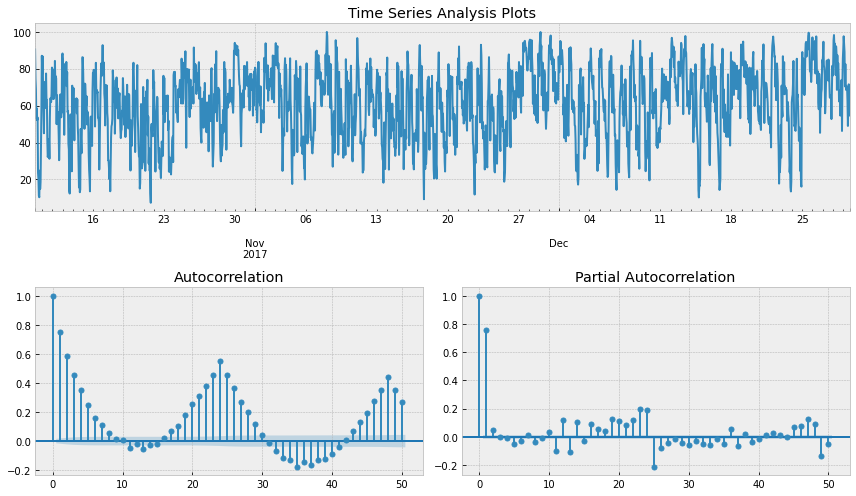

In [41]:
tsplot(resampled_data.utilization, lags=50)

In [10]:
def plot_moving_average(series, n, plot_actual=True):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений (!!!)
    rolling_std =  series.rolling(window=n).std()
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(25,10))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    if plot_actual:
        plt.plot(dataset[n:], 'b', label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

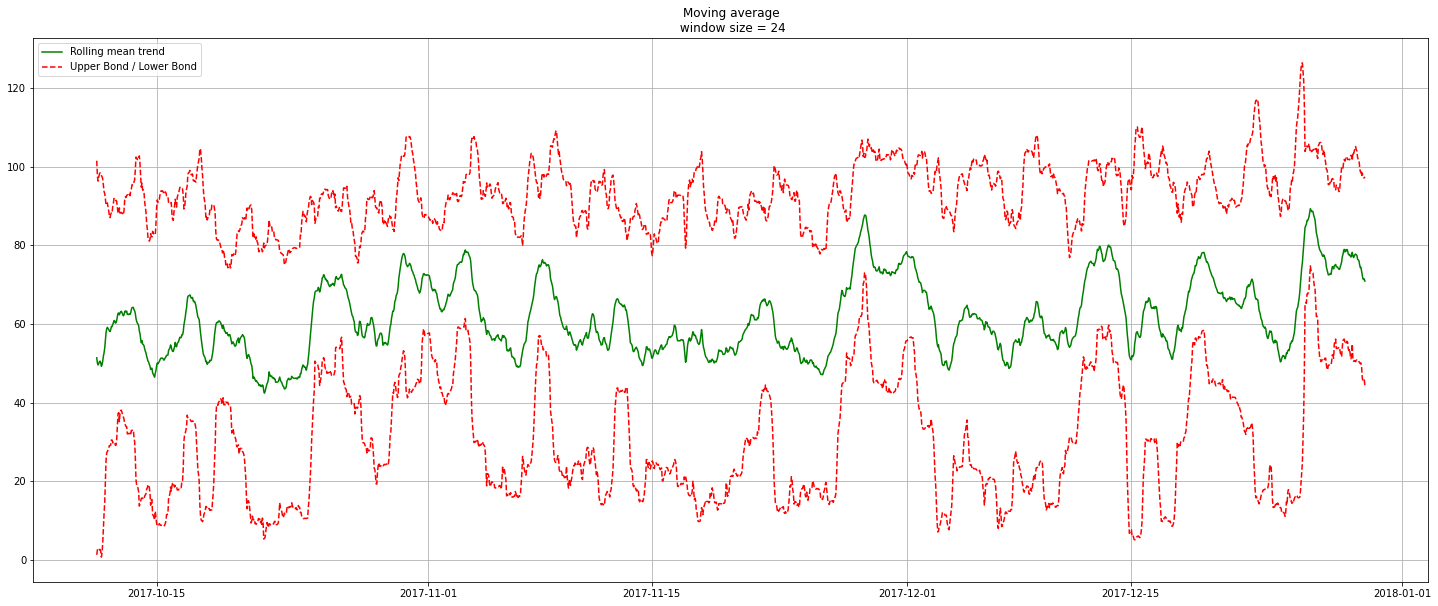

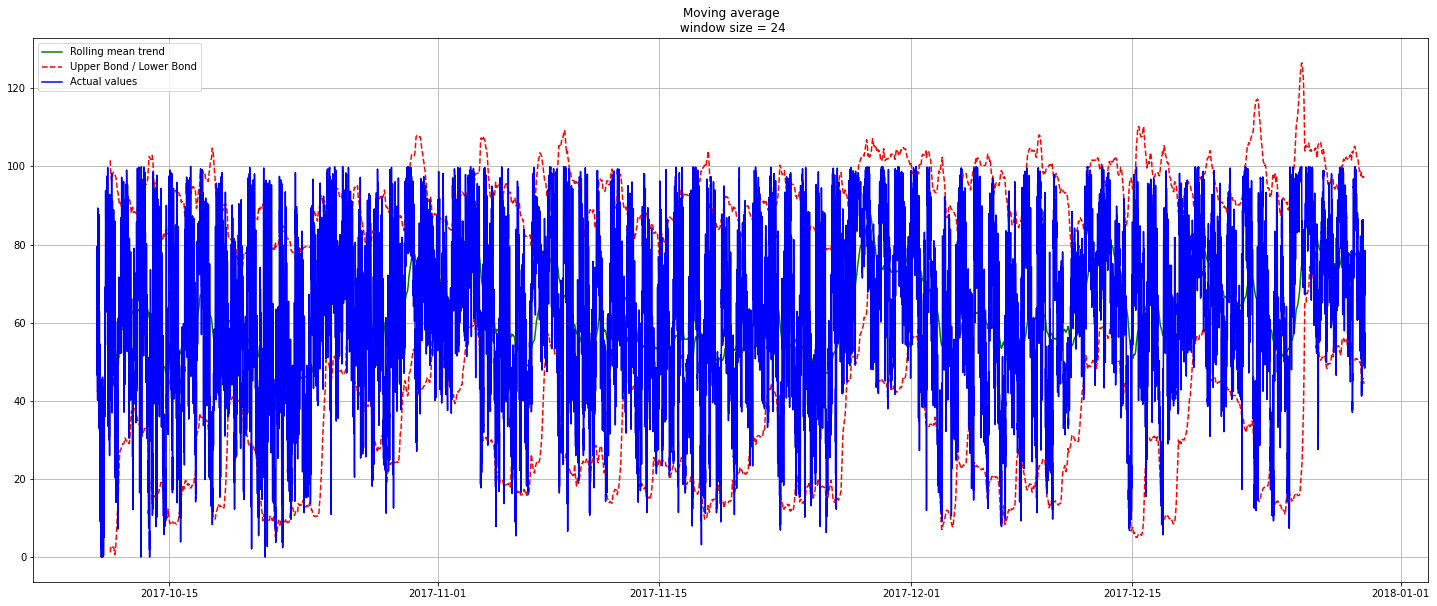

In [42]:
plot_moving_average(resampled_data, 24, plot_actual=False) # 24 часа
plot_moving_average(resampled_data, 24) # 24 часа

In [12]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [26]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [20]:
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [48]:
%%time
data = resampled_data.utilization[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.012095813709154635 0.017669664030937726 0.04846708626521368
CPU times: user 23.6 s, sys: 0 ns, total: 23.6 s
Wall time: 23.6 s


In [95]:
PREDICTION_POINTS = 24 * 7

In [96]:
# Передаем оптимальные значения модели, 
data = resampled_data.utilization
model = HoltWinters(data[:-PREDICTION_POINTS], slen = 24, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = PREDICTION_POINTS, scaling_factor = 2.56)
model.triple_exponential_smoothing()

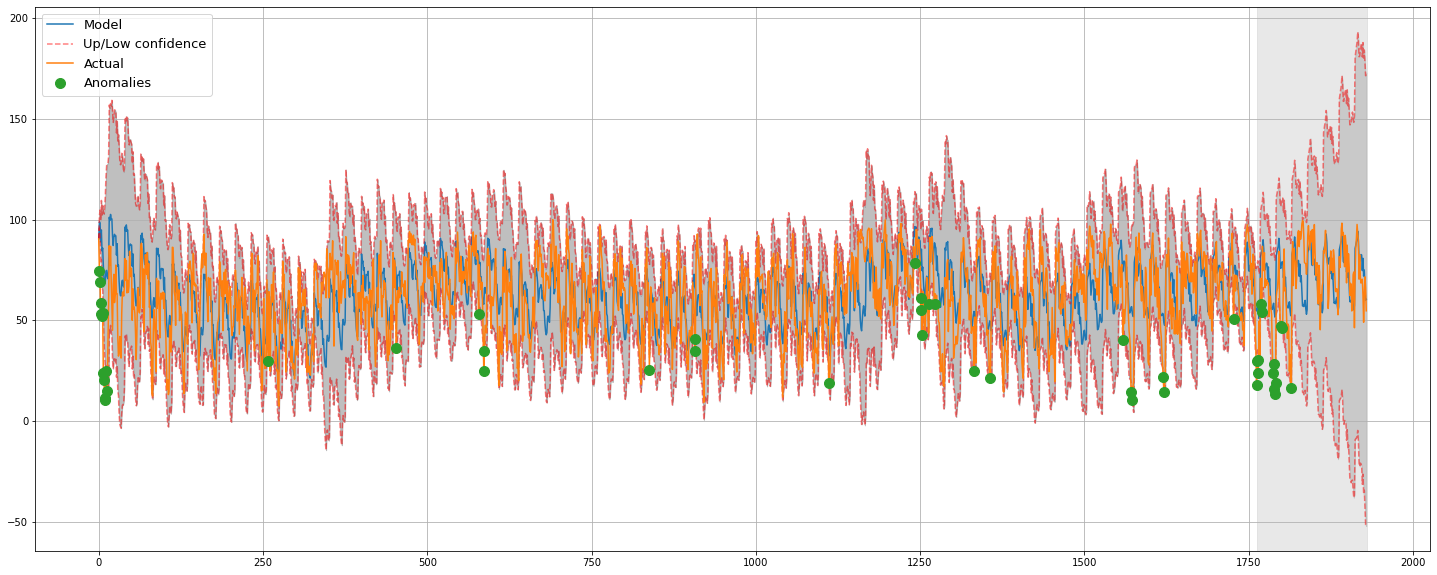

In [97]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-PREDICTION_POINTS, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

In [77]:
pred_start = 0
pred_end = -500

In [99]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
resampled_data.index = pd.DatetimeIndex(resampled_data.index.values, freq=resampled_data.index.inferred_freq)

In [100]:
model = ExponentialSmoothing(resampled_data[pred_start:pred_end], initialization_method="estimated", seasonal_periods=24, seasonal='add') \
    .fit(smoothing_level=alpha_final, smoothing_trend=beta_final, smoothing_seasonal=gamma_final)

In [101]:
pred = model.predict(start='2017-10-10 07:00:00', end='2017-12-30 12:00:00')

<AxesSubplot:>

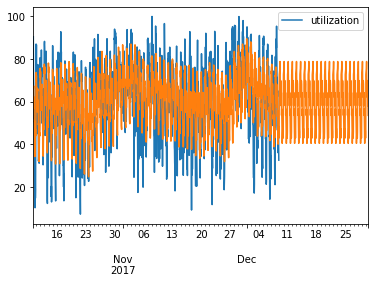

In [102]:
resampled_data[pred_start:pred_end].plot(label='Test')
pred.plot(label='Test')

In [103]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [107]:
data_for_ml = pd.DataFrame(resampled_data)
data_for_ml.columns = ["y"]
data_for_ml["hour"] = resampled_data.index.hour
data_for_ml.index = pd.to_datetime(resampled_data.index)
data_for_ml.head()

y  hour
2017-10-10 07:00:00  90.397000     7
2017-10-10 08:00:00  74.493000     8
2017-10-10 09:00:00  68.930125     9
2017-10-10 10:00:00  52.874208    10
2017-10-10 11:00:00  58.498275    11

In [108]:
def prepare_data(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

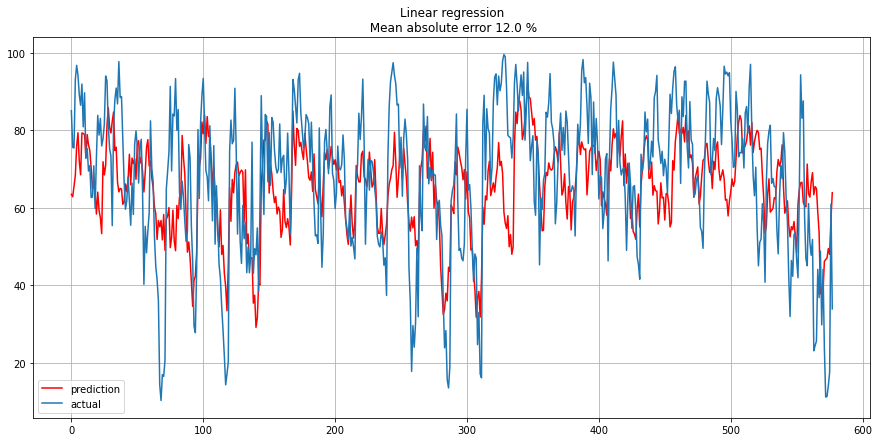

In [127]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepare_data(resampled_data.utilization, test_size=0.3, lag_start=5, lag_end=24*2)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} %".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [133]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print("Size train set: {}".format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print("Size of each fold: {}".format(k))

    errors = np.zeros(number_folds - 1)

    # loop from the first 2 folds to the total number of folds
    for i in range(2, number_folds + 1):
        print()
        split = float(i - 1) / i
        print(
            "Splitting the first " + str(i) + " chunks at " + str(i - 1) + "/" + str(i)
        )

        X = X_train[: (k * i)]
        y = y_train[: (k * i)]
        print(
            "Size of train + test: {}".format(X.shape)
        )  # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1) :]
        y_testFold = y[(index + 1) :]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i - 2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds
    return errors.mean()

In [134]:
%%time
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (1458, 43)
Size of each fold: 291

Splitting the first 2 chunks at 1/2
Size of train + test: (582, 43)

Splitting the first 3 chunks at 2/3
Size of train + test: (873, 43)

Splitting the first 4 chunks at 3/4
Size of train + test: (1164, 43)

Splitting the first 5 chunks at 4/5
Size of train + test: (1455, 43)
CPU times: user 100 ms, sys: 40 ms, total: 140 ms
Wall time: 72.1 ms


11.95088391244574

In [135]:
import xgboost as xgb

In [143]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepare_data(data.utilization, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} %".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

[14:38:37] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:37] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:37] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:37] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:37] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:37] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:37] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:37] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:37] WARNING: ../src/objective/regression_

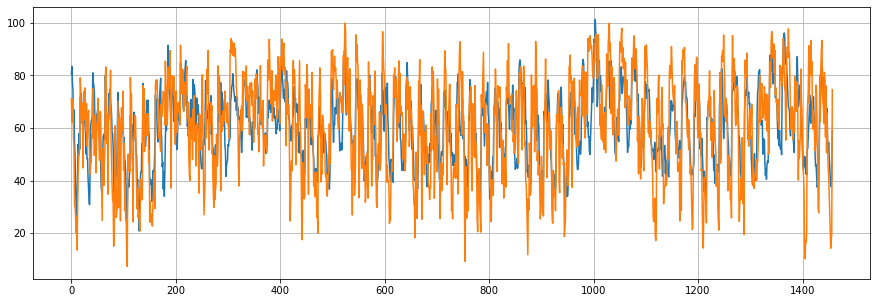

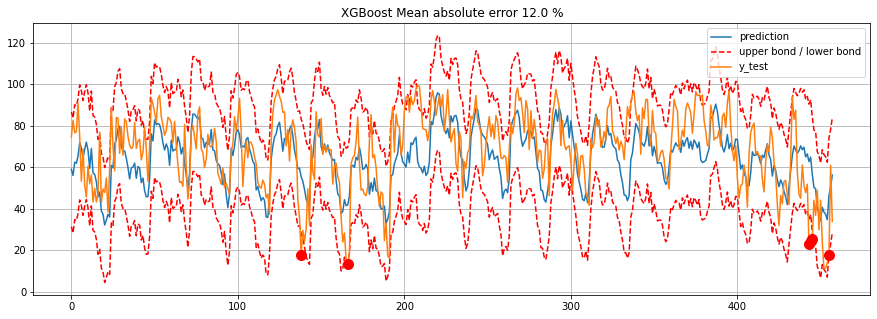

In [144]:
XGB_forecast(resampled_data, test_size=0.3, lag_start=5, lag_end=24*7)